# Setup

In [1]:
import jax
import optax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable, Sequence
from functools import partial
from jax.flatten_util import ravel_pytree

from rebayes.utils.rotating_mnist_data import load_rotated_mnist, load_mnist
from rebayes import base
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils.utils import tree_to_cpu, get_subtree

/home/kpmurphy/.local/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/kpmurphy/.local/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/kpmurphy/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-13 00:27:24.728820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kpmurphy/.local/lib/python3.8/site-packages/flax/struct.py:13

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

# Data

## Rotated MNIST

In [2]:
def load_data(
    anglefn: Callable,
    sort_by_angle: bool = True,
    target_digit = [3, 2],
    num_train = 1000,
    num_test = 1000,
):
    data = load_rotated_mnist(
        anglefn, target_digit=target_digit, sort_by_angle=sort_by_angle, num_train=num_train, num_test=num_test,
    )
    train, test = data
    # "y" = angle, "labels" = digit
    X_train, y_train, labels_train = train
    X_test, y_test, labels_test = test
    labels_train, labels_test = jnp.array(labels_train), jnp.array(labels_test)

    # angles
    ymean, ystd = y_train.mean().item(), y_train.std().item()
    if ystd > 0:
        y_train = (y_train - ymean) / ystd
        y_test = (y_test - ymean) / ystd

    dataset = {
        "train": (X_train, y_train, labels_train),
        "test": (X_test, y_test, labels_test),
    }

    res = {
        "dataset": dataset,
        "ymean": ymean,
        "ystd": ystd,
    }

    return res

In [3]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(-0.5, 1.5, n_configs)
    
    angles = np.exp(t) * np.sin(55 * t)
    angles = np.sin(55 * t)
    
    angles = (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
    
    # angles = np.random.randn(n_configs) / 100
    # angles = np.abs(angles)
    
    return angles

def constant_angle(n_configs, minangle, maxangle, angle=0.0):
    return np.ones(n_configs) * angle


In [9]:
data_name = 'mnist-classif-10class' # string for saving and loading data

output_type = "classification" # "binary", "regression"

if output_type == "classification":
    classes = [0,1,2,3,4,5,6,7,8,9,10]
    dim_out = len(classes)
elif output_type == "binary":
    classes = [2,3]
    dim_out = 1
elif output_type == "regression":
    dim_out = 1

angle_fn = partial(constant_angle, angle=0)
#angle_fn = damp_angle

data = load_data(angle_fn, sort_by_angle=False, target_digit=classes, num_train = 1000, num_test = 1000)
X_train, angle_train, labels_train = data["dataset"]["train"]
X_test, angle_test, labels_test = data["dataset"]["test"]

if output_type == "binary":
    Y_train = jnp.array(labels_train) == 2
    Y_test = jnp.array(labels_test) == 2
elif output_type == "classification":
    Y_train = jax.nn.one_hot(labels_train, dim_out)
    Y_test = jax.nn.one_hot(labels_test, dim_out)
else:
    Y_train = angle_train
    Y_test = angle_test



print(X_train.shape, X_test.shape, labels_train.shape, labels_test.shape)
print(angle_train[:10], labels_train[:10], Y_train[:10])



(1000, 784) (1000, 784) (1000,) (1000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [5 0 4 1 9 2 1 3 1 4] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


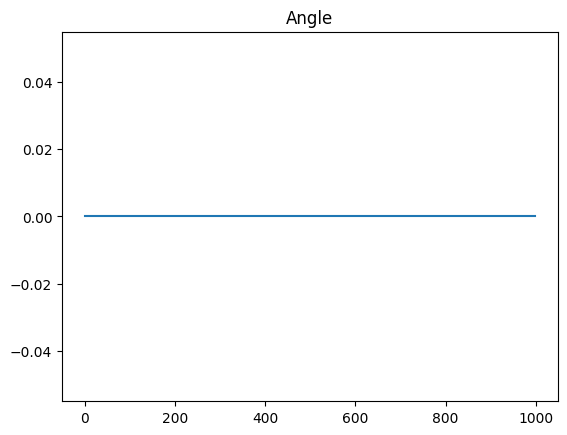

In [5]:
plt.title("Angle")
plt.plot(angle_train)

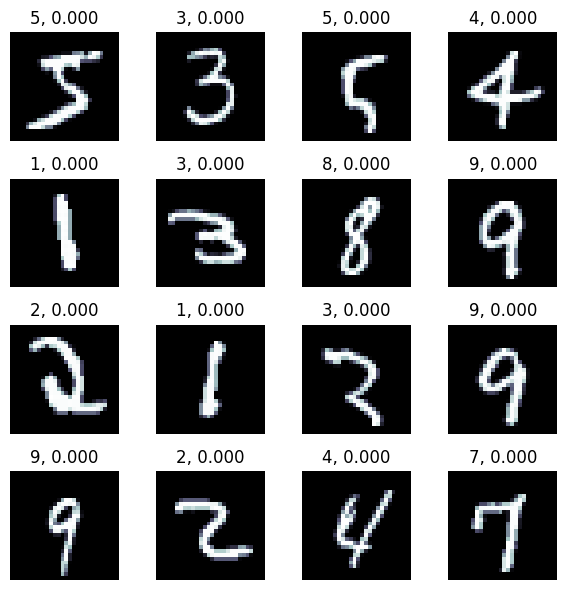

In [7]:
def plot_images(X_train, labels_train, angle_train=None):
    #np.random.seed(314)
    #ixs = np.random.randint(0, len(X_train), size=8)
    if angle_train is None:
        angle_train = np.zeros_like(labels_train)
    ixs = np.arange(16)
    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    axs = axs.ravel()
    for ax, ix in zip(axs, ixs):
        img = X_train[ix]
        angle = angle_train[ix]
        label = labels_train[ix]
        ax.imshow(img.reshape(28, 28), cmap="bone")
        ax.axis("off")
        ax.set_title('{}, {:0.3f}'.format(label, angle))
    plt.tight_layout()

ixs = np.arange(start=0, stop=len(Y_train), step=50)
plot_images(X_train[ixs],  labels_train[ixs], angle_train[ixs])

# Model

In [10]:
# In the classification case, the final layer returns logits
# The user has to apply the softmax function to get the probabilities.

class MLP4(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        return x
    
class MLP(nn.Module):
    n_units: Sequence[int]
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.n_units[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.n_units[-1], name="last-layer")(x)
        return x

In [11]:
def make_bnn_flax(dim_in, dim_out, nhidden):
    key = jax.random.PRNGKey(314) # generalize
    n_units = nhidden + [dim_out]
    model = MLP(n_units)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x, model):
    return model.apply(params, x)


n_train, dim_in = X_train.shape
_, dim_out = Y_train.shape
nhidden=[50,50,50]
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in, dim_out, nhidden)

# "Link function" for the output layer
if output_type == "classification":
    post_apply = lambda logits: jax.nn.softmax(logits)
elif output_type == "binary":
    post_apply = lambda logits: jax.nn.sigmoid(logits)
else:
    post_apply = lambda scores: scores


# concatenate numbers into a string
model_name =  'MLP' +  str([str(x) for x in nhidden])
print(model_name)

# Eval (callback)

In [ ]:
if output_type == "classification":
    def eval_fn(outputs, target):
        return (outputs.argmax(-1) != target).mean()

In [23]:
def callback(bel, pred_obs, t, X, y, bel_pred, apply_fn, **kwargs):
    X_train, y_train, X_test, y_test, forecast = kwargs["X_train"], kwargs["y_train"], kwargs["X_test"], kwargs["y_test"], kwargs["forecast"]
    
    slice_ix = jnp.arange(0, forecast) + t
    X_forecast = jnp.take(X_train, slice_ix, axis=0, fill_value=0)
    y_forecast = jnp.take(y_train, slice_ix, axis=0, fill_value=0)
    y_forecast = y_forecast.argmax(axis=1)
    
    y_next = y.ravel().argmax()
    yhat_next = pred_obs.ravel().argmax()
    err = (y_next == yhat_next).mean()

    #yhat_test = apply_fn(bel.mean, X_test).squeeze().round()
    logits_test = apply_fn(bel.mean, X_test)
    yhat_test = logits_test.argmax(axis=1)
    err_test = (y_test.argmax(axis=1) == yhat_test).mean()

    #yhat_forecast = apply_fn(bel.mean, X_forecast).squeeze().round()
    logits_forecast = apply_fn(bel.mean, X_forecast)
    yhat_forecast = logits_forecast.argmax(axis=1)
    err_forecast = (y_forecast == yhat_forecast).mean()
    
    res = {
        "forecast-error": err_forecast,
        "test-error": err_test,
        "osa-error": err,
    }
    return res

# Lofi

In [25]:
if output_type == "classification":
    def emission_mean_function(w, x):
        return jax.nn.softmax(apply_fn_flat(w, x, model, recfn))
    def emission_cov_function(w, x):
        ps = emission_mean_function(w, x)
        return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity
elif output_type == "binary":
    def emission_mean_function(w, x):
        return jax.nn.sigmoid(apply_fn_flat(w, x, model, recfn))
    def emission_cov_function(w, x):
        ps = emission_mean_function(w, x)
        return 0
else:
    def emission_mean_function(w, x):
        return apply_fn_flat(w, x, model, recfn)
    def emission_cov_function(w, x):
        R = jnp.std(Y_train) # empirical estimate
        return R
    
ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1, # 0.01
        dynamics_weights=1,
        dynamics_covariance=0.0,#1e-3,
        emission_mean_function = emission_mean_function,
        emission_cov_function = emission_cov_function,
        dynamics_covariance_inflation_factor=0.0
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")

In [26]:
%%time
agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

ymean, ystd = data["ymean"], data["ystd"]
callback_part = partial(callback,
                        apply_fn=agent.params.emission_mean_function,
                        X_train=X_train, y_train=Y_train,
                        X_test=X_test, y_test=Y_test, forecast=10
                       )

nsteps = 500
bel, outputs = agent.scan(X_train[:nsteps], Y_train[:nsteps], progress_bar=False, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_lofi = tree_to_cpu(outputs)

CPU times: user 10.6 s, sys: 293 ms, total: 10.8 s
Wall time: 4.35 s


In [27]:
print(outputs_lofi.keys())

dict_keys(['forecast-error', 'osa-error', 'test-error'])


Text(0.5, 1.0, 'lofi, memory size = 10')

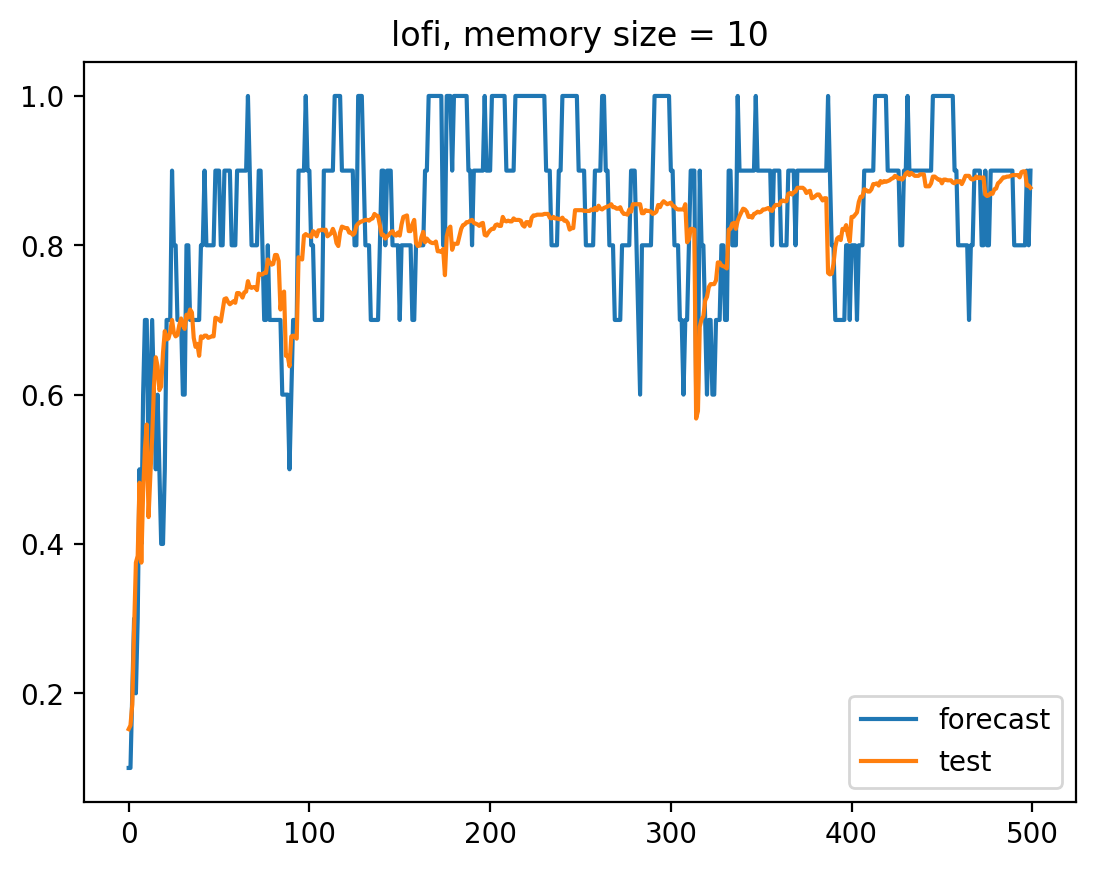

In [29]:
plt.figure()
plt.plot(outputs_lofi["forecast-error"], label="forecast")
# plt.plot(outputs_lofi["osa-error"], label="osa")
plt.plot(outputs_lofi["test-error"], label="test")
plt.legend()
plt.title('lofi, memory size = {}'.format(mem))

# Replay SGD

In [30]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_crossent_fifo(params, counter, X, y, applyfn):
    
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    #probs = jax.nn.sigmoid(logits)
    
    nll = -y * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss


In [31]:
%%time
lr, buffer = 5e-4, 10
agent = rsgd.FifoSGD(lossfn_crossent_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size=buffer,
                    dim_features=X_train.shape[1],
                    dim_output=dim_out,
                    n_inner=1)


callback_part = partial(callback,
                        apply_fn=agent.apply_fn,
                        X_train=X_train, y_train=Y_train,
                        X_test=X_test, y_test=Y_test, forecast=10
                       )

bel, outputs = agent.scan(X_train[:nsteps], Y_train[:nsteps], progress_bar=False, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd_adam = tree_to_cpu(outputs)



CPU times: user 2.68 s, sys: 12.2 ms, total: 2.69 s
Wall time: 1.68 s


Text(0.5, 1.0, 'SGD Replay (Adam), buffer 10, lr 0.00')

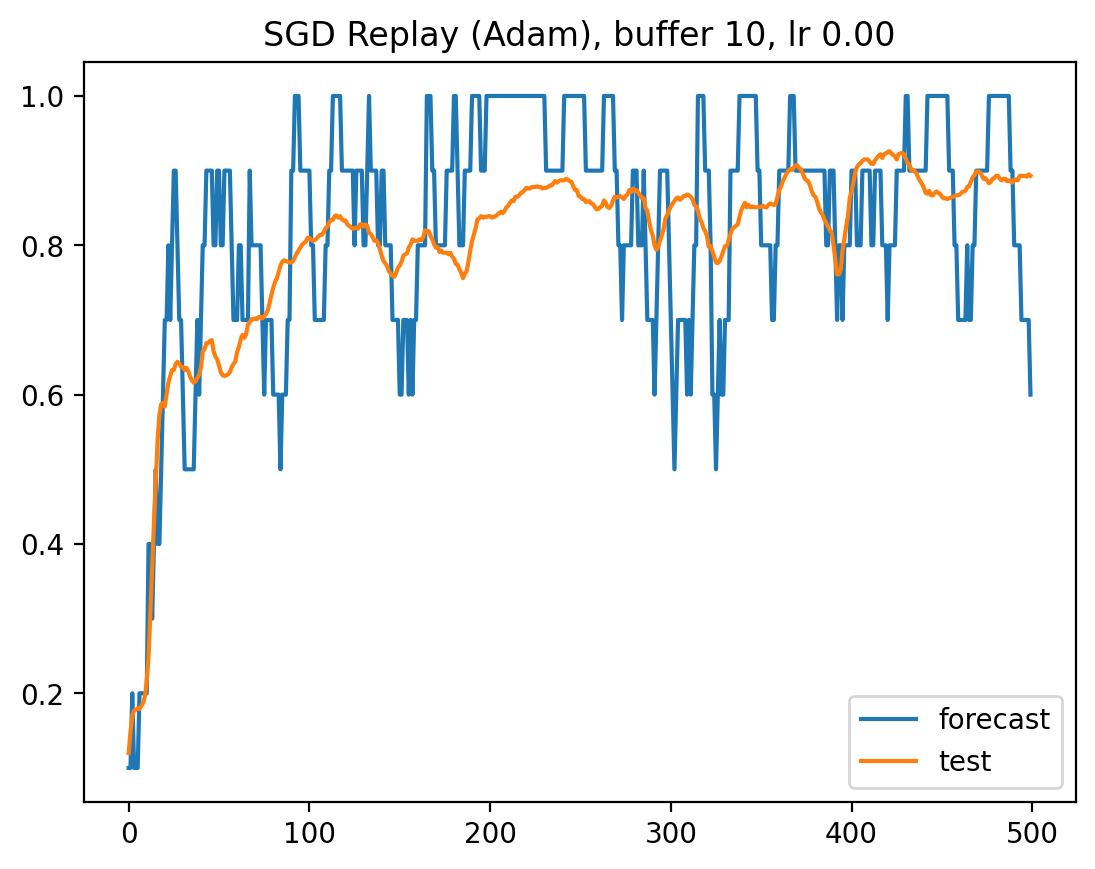

In [32]:
plt.figure()
plt.plot(outputs_rsgd_adam["forecast-error"], label="forecast")
# plt.plot(outputs_rsgd_adam["osa-error"], label="osa")
plt.plot(outputs_rsgd_adam["test-error"], label="test")
plt.legend()
plt.title('SGD Replay (Adam), buffer {}, lr {:0.2f}'.format(buffer, lr))